## Imports

In [1]:
import torch 
import unidecode
import random
import numpy as np
import matplotlib.pyplot as plt

from models.PG_agent import PolicyGradientAgent
from models.charRNN import make_charRNN, get_random_batch, generate
from utils import n_chars, all_chars, check_validity, check_novelty, strsmis2listsmis, list2txt, get_props

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the general generator:
* please see the file PG_agent.py inside the models folder for the code behind the developed model

In [3]:
lr = 0.00005 

In [25]:
model_name =  'G'   
agent = PolicyGradientAgent(n_chars=n_chars, hidden_size=512, num_layers=3, 
                            output_size=n_chars, lr=lr, policy_file=model_name)

In [26]:
print(agent.policy)

RNN(
  (embed): Embedding(56, 30)
  (gru): GRU(30, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=56, bias=True)
)


# Training function:

In [27]:
obj='_3_'

In [28]:
def train_REINFORCE(n_epochs, k=1): 
    scores = []
    smis = []
    prev_high_r = 0
    score = 0
    best_model = 'models/pretrained/RL' + obj + str(n_epochs) +'_'+ str(k)+'_ep.pth'
    for i in range(n_epochs):
        done = False
        ic = '<' 
        observation = all_chars.index(ic)
        step = 0
        length = 102  #max_length
        smi = ''
        while not done:
            action = agent.choose_action(observation) 
            pred_char = all_chars[action]
            if pred_char=='>' or step==length:  #if any of the terminal conditions is reached ----
                prop1, prop2, prop3, prop4, prop5 = get_props(smi, c=1)

                if prop1<=3 and prop2<=480 and prop3<=3 and prop4<=3 and prop5<=3: # -------------------------------
                    reward = 10             
    
                score += reward
                agent.store_rewards(reward)
                done = True
            
            else:                              #if terminal conditions are not reached yet -----
                smi += pred_char
                reward = 0                     #step reward = 0 
                score += reward
                step += 1
                ic = pred_char 
                observation = all_chars.index(ic)
            agent.store_rewards(reward)
        
        if (i+1) % k == 0:  #learn each k episodes 
            agent.learn()
            avg_score = score/(k*10)
            scores.append(avg_score)
            print("episod: ", i, "episodic reward: ", avg_score)
            score = 0
            
        if prev_high_r < reward:
            prev_high_r = reward
            agent.save_policy(best_model)
    return scores

In [4]:
## --- for reproducibility of the results ---
seeds = [3, 0, 3]
torch.manual_seed(seeds[0])
np.random.seed(seeds[1])
random.seed(seeds[2])

In [5]:
str(seeds)

'[3, 0, 3]'

In [35]:
k = 20  
n_epochs = 800*k  
scores = train_REINFORCE(n_epochs, k=k)   

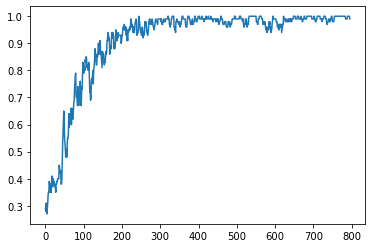

In [37]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

smooth_score = moving_average(scores, 5)
plt.plot(smooth_score)
plt.savefig('gen_smis/RL_obj3.png', dpi=300)

In [33]:
# np.savetxt('RL_scores_3_.txt', scores, delimiter=',')

## 0. generate: 

In [19]:
# model_name = 'RL' + obj + str(n_epochs) +'_'+ str(k)+'_ep'   #or use the provided one
model_name = 'RL_3'
agent = PolicyGradientAgent(n_chars=n_chars, hidden_size=512, num_layers=3, 
                            output_size=n_chars, policy_file= model_name)
print(model_name)

In [7]:
rnn = agent.policy

In [8]:
RL_temp = 0.5   

In [20]:
n_ep = 10000
all_smis = []
for ep in range(n_ep):
    length = 102
    ic = '<'
    smi = generate(rnn, initial_str=ic, predict_len=length, temperature=RL_temp)
    all_smis.append(smi)
    print("iteration:", ep)

In [ ]:
### save the list of generated smiles if you want
# filename = model_name + '_all_smis_.txt'
# path = 'gen_smis/' + filename
# list2txt(path, mylist=all_smis)

## 1. How many among all_smis are valid:

In [21]:
val_smis = []
for i, s in enumerate(all_smis):
    v = check_validity(s)
    if v == 1:
        val_smis.append(s)
        print("mol at:", i, " : verified")

In [2]:
# print("There is ", len(val_smis), "valid molecule among the", len(all_smis), "generated")
# print("meaning a percent of: ", 100 * len(val_smis)/len(all_smis), "%")

## 2. How many among val_smis are novel:

In [22]:
file = unidecode.unidecode(open('all_data/s_100_str_+1M.txt').read())
smis_list = strsmis2listsmis(file)
len(smis_list)

In [23]:
val_and_nov_smis = []
for i, s in enumerate(val_smis):
    nv = check_novelty(s, smis_list)
    if nv == 1:
        val_and_nov_smis.append(s)
        print("mol at:", i, " : verified")

In [24]:
print("There is ", len(val_and_nov_smis), "valid & novel molecule among the", len(all_smis), "generated")
print("meaning a percent of: ", 100 * len(val_and_nov_smis)/ len(val_smis), "%")

## 3. How many among valid_and_novel_smis are unique 
* meaning, they don't have duplicates/were not repeated in the generated molecules

In [14]:
def check_uniqueness(smis_list):
    return list(set(smis_list))

val_nov_and_unique_smis = check_uniqueness(val_and_nov_smis)

In [25]:
print("There is ", len(val_nov_and_unique_smis), "valid, novel and unique molecule among the", len(all_smis), "generated")
print("meaning, a percent of : ", 100 * len(val_nov_and_unique_smis)/ len(val_and_nov_smis), "%")

## 4. Diversity (intDiv) of the valid, novel, and unique smiles:
* using the moses library https://github.com/molecularsets/moses

In [26]:
import moses
moses.metrics.internal_diversity(val_nov_and_unique_smis)

## 5. How many have the desired chemical property:

In [17]:
succ = []
for i, smi in enumerate(val_nov_and_unique_smis):
    prop1, prop2, prop3, prop4, prop5 = get_props(smi, c=1)
    if prop1<=3 and prop2<=480 and prop3<=3 and prop4<=3 and prop5<=3:
        succ.append(smi)

In [27]:
print('there is', len(succ), 'molecule with the desired property')
print("meaning a percent of", 100 * len(succ)/len(val_nov_and_unique_smis), "% of smiles among the valid, \
novel and unique ones with the desired property")